# Model Interpretability
We'll interpret our model's predictions using LIME (Local Interpretable Model-agnostic Explanations). LIME helps us understand which words in a review most strongly influence the model's classification decisions.
We start by copying the necessary code we need from the previous notebook so we can start interpreting using LIME.


In [4]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


processed_path = "../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)
df['label'] = df['polarity'].map({1: 0, 2: 1})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = load_model('best_model.keras')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen = 70  


Now we'll use LIME to analyze how the model makes its decisions and then visualize which words contribute most to positive/negative sentiment predictions.
We'll create a prediction function that:
1. Converts text to sequences using our tokenizer
2. Pads sequences to the required length
3. Gets predictions from our model
4. Returns probabilities for both negative and positive classes.

Finally, we'll display the models prediction, showing the original text, the top words that influenced the prediction, and list the contribution score for each word

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 1000x400 with 0 Axes>

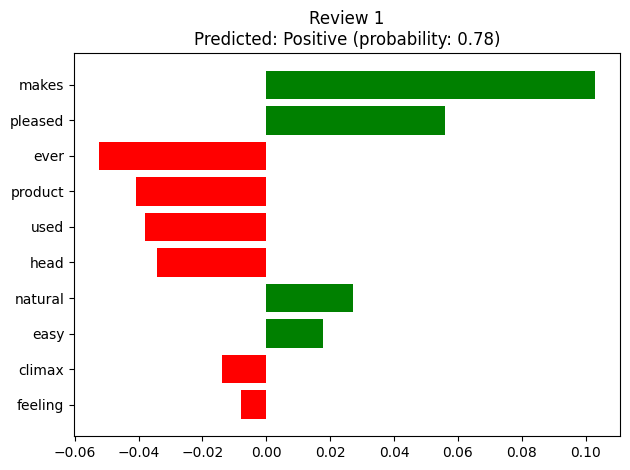


Review 1:
Text: easy climax im pleased product natural feeling head makes climaxing easyand used bathtubshower ever...

Top contributing words:
makes: 0.103
pleased: 0.056
ever: -0.052
product: -0.041
used: -0.038
head: -0.034
natural: 0.027
easy: 0.018
climax: -0.014
feeling: -0.008


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<Figure size 1000x400 with 0 Axes>

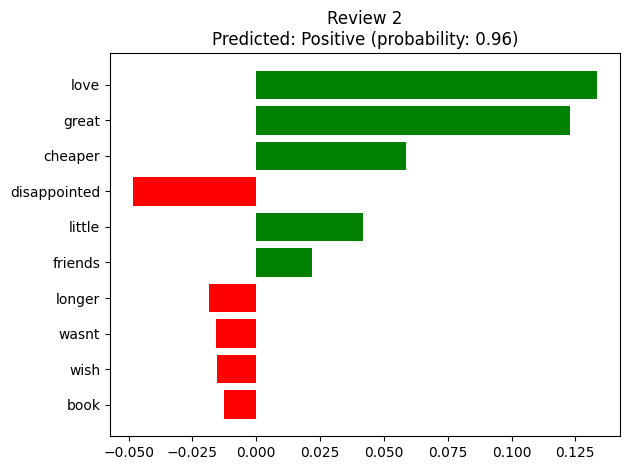


Review 2:
Text: short book explaining love logic first disappointed wasnt longer book realized great give away curio...

Top contributing words:
love: 0.133
great: 0.123
cheaper: 0.059
disappointed: -0.048
little: 0.042
friends: 0.022
longer: -0.019
wasnt: -0.016
wish: -0.015
book: -0.013


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

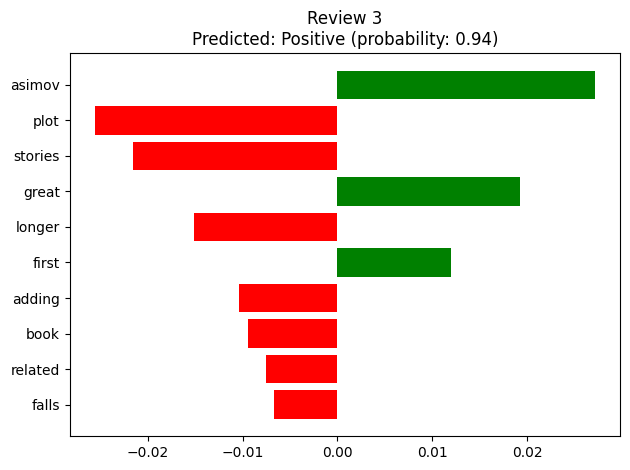


Review 3:
Text: foundation unlike first foundation book series related interconnected stories foundation empire two ...

Top contributing words:
asimov: 0.027
plot: -0.026
stories: -0.022
great: 0.019
longer: -0.015
first: 0.012
adding: -0.010
book: -0.009
related: -0.008
falls: -0.007


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

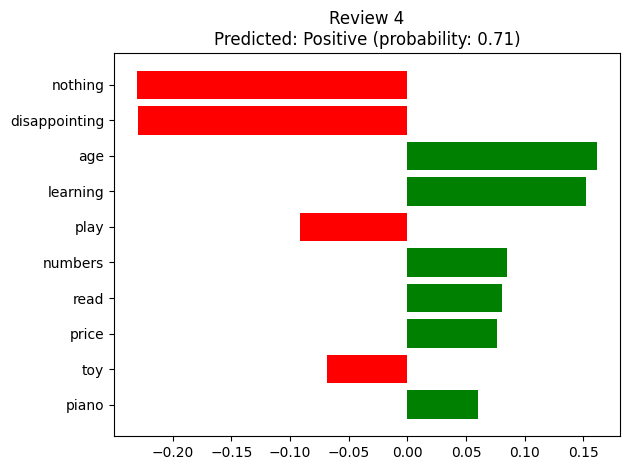


Review 4:
Text: quite piano book looking piano songbook childern play piano realized songbook price comes electronic...

Top contributing words:
nothing: -0.230
disappointing: -0.229
age: 0.162
learning: 0.153
play: -0.091
numbers: 0.085
read: 0.080
price: 0.077
toy: -0.068
piano: 0.060


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

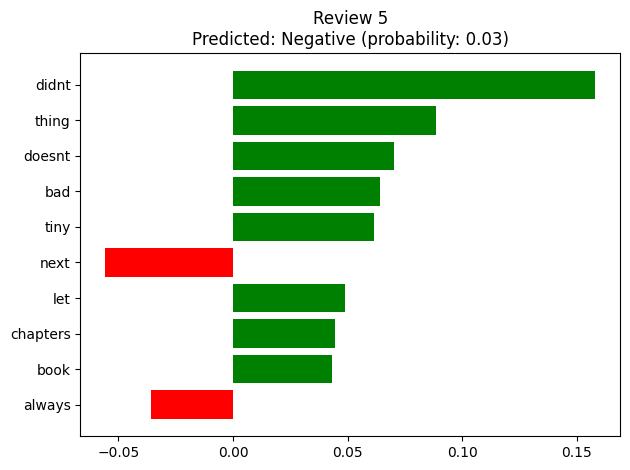


Review 5:
Text: ok nothing great bad book expected didnt find locked waiting next thing happen unable put one thing ...

Top contributing words:
didnt: 0.158
thing: 0.088
doesnt: 0.070
bad: 0.064
tiny: 0.061
next: -0.056
let: 0.049
chapters: 0.045
book: 0.043
always: -0.036




In [5]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#function to predict probabilities
def predict_prob(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    preds = best_model.predict(padded)
    return np.array([[1-p[0], p[0]] for p in preds])

#create LIME explainer and get sample texts
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
num_examples = 5
sample_indices = np.random.choice(len(X_test), num_examples)
sample_texts = X_test.iloc[sample_indices].values

#nalyze each example
for idx, text in enumerate(sample_texts):
    exp = explainer.explain_instance(
        text, 
        predict_prob,
        num_features=10,
        top_labels=1
    )
    
    pred_probs = predict_prob([text])[0]
    pred_class = 'Positive' if pred_probs[1] > 0.5 else 'Negative'
    explained_label = exp.available_labels()[0]
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure(label=explained_label)
    plt.title(f'Review {idx+1}\nPredicted: {pred_class} (probability: {pred_probs[1]:.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nReview {idx+1}:")
    print(f"Text: {text[:100]}...")
    print("\nTop contributing words:")
    for word, score in exp.as_list(label=explained_label):
        print(f"{word}: {score:.3f}")
    print("\n" + "="*50 + "\n")